Раскидывание данных для первого водителя по массивам:

In [8]:
%matplotlib inline
import pandas
import math
import matplotlib.pyplot as plt
import re
import datetime
import sort_coordinates

data = pandas.read_csv('data1.tsv', sep="\t")
id_unique = data["id"].unique()
date_points = []
lat_points = []
lon_points = []
format_date = "%Y-%m-%d %H:%M:%S"

for i in id_unique:
    str_date = data[data["id"] == i]["date"].copy()
    datepstr = []
    for s in str_date:
        t = datetime.datetime.strptime(s, format_date)
        datepstr.append(t)
    date_points.append(datepstr)
    lat = sort_coordinates.del_invalid_idx(data[data["id"] == i]["latitude"].copy())
    lat_points.append(lat)
    lon = sort_coordinates.del_invalid_idx(data[data["id"] == i]["longitude"].copy())
    lon_points.append(lon)

SyntaxError: invalid syntax (<ipython-input-8-c6d5fb7299ff>, line 7)

Нужно придумать как определять число остановок и предварительно разделить маршрут на 2 части - в одну и в другую сторону.

In [9]:
import rounds
lat = []
lon = []
for i in range(len(lon_points)):
    x, y = rounds.div_rounds(lat_points[i], lon_points[i], date_points[i]);
    for idx in range(len(x)):
        lat.append(x[idx])
        lon.append(y[idx])
  

32 430


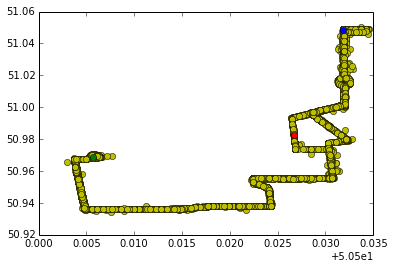

In [10]:
plt.plot(data["latitude"], data["longitude"], 'o', c = 'y')

i = 0
j = 29
plt.plot(lat[j][i], lon[j][i], 'o', c = 'g')
i=len(lat[j])-1
print(len(lat), len(lat[j]))
plt.plot(lat[j][i], lon[j][i], 'o', c = 'b')
i=int((len(lat[j])-1)/2)
plt.plot(lat[j][i], lon[j][i], 'o', c = 'r')


Этот график проверка, что данные отделяются верно. Ещё не много стоит его доработать.